In [1]:
import os
os.environ["SPARK_LOCAL_IP"] = "10.0.0.123"
import sys

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession

In [2]:
from pyspark.sql.functions import col, regexp_extract
from pyspark.sql.functions import from_unixtime, col, year, month, quarter, avg, count, when, isnan, least, greatest, max, min, lit, when
from functools import reduce
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import pandas as pd
import numpy as np
from numpy import polyfit, polyval

In [3]:
spark = (
    SparkSession.builder
    .appName("GDP_Analysis")
    .master("local[*]")
    .config("spark.driver.memory", "12g")
    .config("spark.ui.port", "4050")
    .config("spark.sql.shuffle.partitions", "50")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .config("spark.sql.autoBroadcastJoinThreshold", "104857600")
    .config("spark.driver.host", "10.0.0.123")
    .getOrCreate()
)

sc = spark.sparkContext
sc.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/05 12:36:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [48]:
import pandas as pd
from pandas_datareader import data as pdr
import datetime

# Set date range to match your GDP/sentiment data
start = datetime.datetime(1996, 1, 1)
end = datetime.datetime(2023, 12, 31)

# Download data
rates = pdr.get_data_fred('FEDFUNDS', start, end)

# Clean and save
rates = rates.reset_index()
rates.columns = ['date', 'interest_rate']  # Rename columns
rates.to_csv("fed_funds_rate.csv", index=False)

In [51]:
!gdown "https://drive.google.com/uc?id=1F7vjh_2WjuOcXsopxnVRt_vMlS7gYpPG"
!gdown "https://drive.google.com/uc?id=1vkgO0QrsPUuJ4-aPPLdJMsBdDRKlm-Hn"
!gdown "https://drive.google.com/uc?id=1tYTp6Pmi9z2tuuEv7fS3kct_RFWbMcz9"
!gdown "https://drive.google.com/uc?id=1PPBuvu2DUxgQFxkMYJw6wAM4ZOJMy2v9"

Downloading...
From: https://drive.google.com/uc?id=1F7vjh_2WjuOcXsopxnVRt_vMlS7gYpPG
To: /Users/evelyn/Downloads/DSC232R/Jupyter Lab/Inflation.csv
100%|████████████████████████████████████████| 188k/188k [00:00<00:00, 5.61MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vkgO0QrsPUuJ4-aPPLdJMsBdDRKlm-Hn
To: /Users/evelyn/Downloads/DSC232R/Jupyter Lab/GDP_perCapita.csv
100%|████████████████████████████████████████| 191k/191k [00:00<00:00, 4.83MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tYTp6Pmi9z2tuuEv7fS3kct_RFWbMcz9
To: /Users/evelyn/Downloads/DSC232R/Jupyter Lab/unemployment_rate.csv
100%|██████████████████████████████████████████| 604/604 [00:00<00:00, 1.93MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PPBuvu2DUxgQFxkMYJw6wAM4ZOJMy2v9
To: /Users/evelyn/Downloads/DSC232R/Jupyter Lab/fed_funds_rate.csv
100%|██████████████████████████████████████| 5.35k/5.35k [00:00<00:00, 9.33MB/s]


In [55]:
# Read the GDP data - ONlY for US
spark.conf.set("spark.sql.debug.maxToStringFields", "100")
years_to_drop = [str(year) for year in range(1960, 1996)] + ["Unnamed: 69", "2024"]

gdp_df = spark.read.option("header", "true").csv("GDP_perCapita.csv")
inf_df = spark.read.option("header", "true").csv("Inflation.csv")
unemp_df = spark.read.option("header", "true").csv("unemployment_rate.csv")
int_df = spark.read.option("header", "true").csv("fed_funds_rate.csv")

US_gdp = gdp_df.filter(gdp_df["Country Name"] == "United States").drop(*years_to_drop)
US_inf = inf_df.filter(inf_df["Country Name"] == "United States").drop(*years_to_drop)
US_unemp = unemp_df.select(col("year").cast("int"),col("unemployment_rate").cast("double"))
US_int = (int_df.withColumn("year", year(col("date"))).select("year", "interest_rate").withColumn("year", col("year").cast("int")).withColumn("interest_rate", col("interest_rate").cast("double")).filter((col("year") >= 1996) & (col("year") <= 2023)).orderBy("year"))


In [8]:
US_gdp.select([count(when(col(c).isNull(), c)).alias(c) for c in US_gdp.columns]).show()

+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|Country Name|Country Code|Indicator Name|Indicator Code|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021|2022|2023|
+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|           0|           0|             0|             0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|
+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+



In [10]:
US_unemp.select([count(when(col(c).isNull(), c)).alias(c) for c in US_unemp.columns]).show()

+----+-----------------+
|year|unemployment_rate|
+----+-----------------+
|   0|                0|
+----+-----------------+



In [11]:
US_inf.select([count(when(col(c).isNull(), c)).alias(c) for c in US_inf.columns]).show()

+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|Country Name|Country Code|Indicator Name|Indicator Code|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021|2022|2023|
+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|           0|           0|             0|             0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|
+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+



In [56]:
US_int.select([count(when(col(c).isNull(), c)).alias(c) for c in US_int.columns]).show()

+----+-------------+
|year|interest_rate|
+----+-------------+
|   0|            0|
+----+-------------+



In [59]:

year_columns = gdp_df.columns[4:]

for year in year_columns:
    gdp_df = gdp_df.withColumn(year, col(year).cast("double"))
    inf_df = inf_df.withColumn(year, col(year).cast("double"))

# Replace nulls with 0 (to safely compute sum)
gdp_exprs = [when(col(y).isNull(), 0).otherwise(col(y)) for y in year_columns]
inf_exprs = [when(col(y).isNull(), 0).otherwise(col(y)) for y in year_columns]

# Sum row-wise
gdp_sum_expr = reduce(lambda a, b: a + b, gdp_exprs)
inf_sum_expr = reduce(lambda a, b: a + b, inf_exprs)

# Max/Min
max_col = greatest(*[col(y) for y in year_columns])
min_col = least(*[col(y) for y in year_columns])

# Stats
gdp_stat = gdp_df.select(max_col.alias("max_gdp"),min_col.alias("min_gdp"),(gdp_sum_expr / len(year_columns)).alias("avg_gdp"))
inf_stat = inf_df.select(max_col.alias("max_inf"),min_col.alias("min_inf"),(inf_sum_expr / len(year_columns)).alias("avg_inf"))
unemp_stat = US_unemp.select(max("unemployment_rate").alias("max_unemp"),min("unemployment_rate").alias("min_unemp"),avg("unemployment_rate").alias("avg_unemp"))
int_stat = US_int.select(max("interest_rate").alias("max_int"),min("interest_rate").alias("min_int"),avg("interest_rate").alias("avg_int"))

# Collect and print
s1 = gdp_stat.collect()[0]
s2 = inf_stat.collect()[0]
s3 = unemp_stat.collect()[0]
s4 = int_stat.collect()[0]

def format_stat(val):
    return f"{val:.2f}" if val is not None else "N/A"

print(f"GDP Stats - Max: {format_stat(s1['max_gdp'])}, Min: {format_stat(s1['min_gdp'])}, Avg: {format_stat(s1['avg_gdp'])}")
print(f"Inflation Stats - Max: {format_stat(s2['max_inf'])}, Min: {format_stat(s2['min_inf'])}, Avg: {format_stat(s2['avg_inf'])}")
print(f"Unemployment Stats - Max: {format_stat(s3['max_unemp'])}, Min: {format_stat(s3['min_unemp'])}, Avg: {format_stat(s3['avg_unemp'])}")
print(f"Interest Stats - Max: {format_stat(s4['max_int'])}, Min: {format_stat(s4['min_int'])}, Avg: {format_stat(s4['avg_int'])}")

GDP Stats - Max: 25.15, Min: -25.79, Avg: 1.10
Inflation Stats - Max: 6.83, Min: -4.91, Avg: 1.63
Unemployment Stats - Max: 9.61, Min: 3.63, Avg: 5.62
Interest Stats - Max: 6.54, Min: 0.05, Avg: 2.28


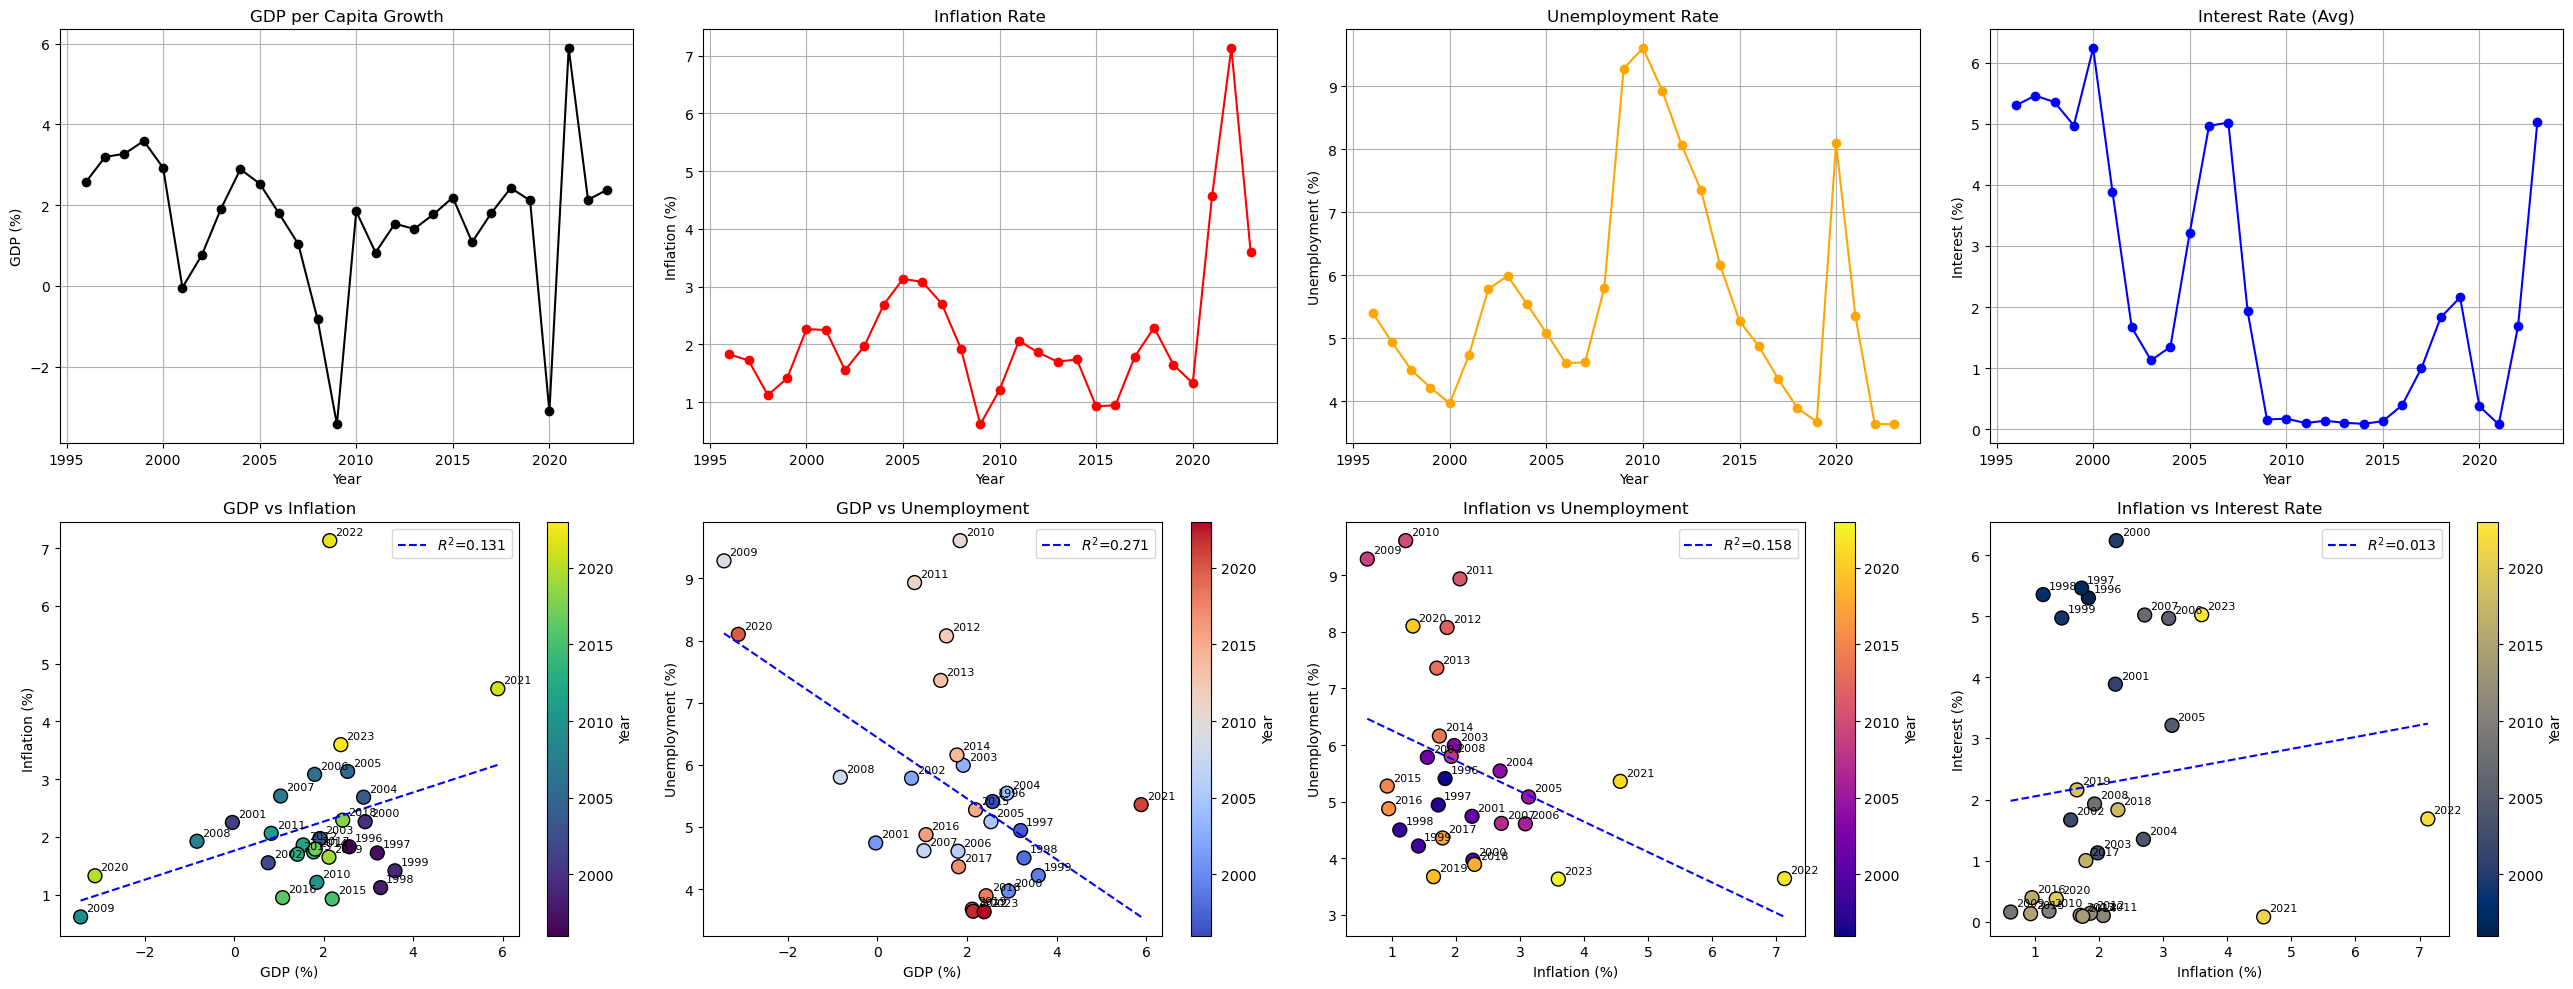

In [69]:
#GDP and Inflation: Wide-format
gdp_pd = US_gdp.select([str(year) for year in range(1996, 2024)]).toPandas().iloc[0].astype(float).values
inf_pd = US_inf.select([str(year) for year in range(1996, 2024)]).toPandas().iloc[0].astype(float).values

#unemployment: Long-format
unemp_pd = (
    US_unemp
    .filter(col("year").between(1996, 2023))
    .orderBy("year")
    .select("unemployment_rate")
    .toPandas()
    .astype(float)
    .values
).flatten()

#interest rate: aggregate to annual average
US_int = US_int.withColumn("year", col("year").cast("int"))
int_yearly_df = (
    US_int
    .filter((col("year") >= 1996) & (col("year") <= 2023))
    .groupBy("year")
    .agg(avg("interest_rate").alias("avg_interest_rate"))
    .orderBy("year")
)
int_pd = int_yearly_df.select("avg_interest_rate").toPandas().astype(float).values.flatten()

years = list(range(1996, 2024))

#plot data
fig, axes = plt.subplots(2, 4, figsize=(26, 10))

#first row - time Series Plots
axes[0, 0].plot(years, gdp_pd, marker='o', color='black')
axes[0, 0].set_title("GDP per Capita Growth")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("GDP (%)")
axes[0, 0].grid(True)

axes[0, 1].plot(years, inf_pd, marker='o', color='red')
axes[0, 1].set_title("Inflation Rate")
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("Inflation (%)")
axes[0, 1].grid(True)

axes[0, 2].plot(years, unemp_pd, marker='o', color='orange')
axes[0, 2].set_title("Unemployment Rate")
axes[0, 2].set_xlabel("Year")
axes[0, 2].set_ylabel("Unemployment (%)")
axes[0, 2].grid(True)

axes[0, 3].plot(years, int_pd, marker='o', color='blue')
axes[0, 3].set_title("Interest Rate (Avg)")
axes[0, 3].set_xlabel("Year")
axes[0, 3].set_ylabel("Interest (%)")
axes[0, 3].grid(True)

#second row - correlation Plots
def add_scatter(ax, x, y, xlab, ylab, title, cmap):
    sc = ax.scatter(x, y, c=years, cmap=cmap, s=100, edgecolors='black')
    for i, yr in enumerate(years):
        ax.annotate(str(yr), (x[i], y[i]), xytext=(4, 4), textcoords='offset points', fontsize=8)
    slope, intercept = polyfit(x, y, 1)
    x_vals = np.linspace(np.min(x), np.max(x), 100)
    y_fit = polyval([slope, intercept], x_vals)
    r2 = 1 - np.sum((y - polyval([slope, intercept], x))**2) / np.sum((y - np.mean(y))**2)
    ax.plot(x_vals, y_fit, 'b--', label=f'$R^2$={r2:.3f}')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.legend()
    plt.colorbar(sc, ax=ax, label='Year')

add_scatter(axes[1, 0], gdp_pd, inf_pd, "GDP (%)", "Inflation (%)", "GDP vs Inflation", 'viridis')
add_scatter(axes[1, 1], gdp_pd, unemp_pd, "GDP (%)", "Unemployment (%)", "GDP vs Unemployment", 'coolwarm')
add_scatter(axes[1, 2], inf_pd, unemp_pd, "Inflation (%)", "Unemployment (%)", "Inflation vs Unemployment", 'plasma')
add_scatter(axes[1, 3], inf_pd, int_pd, "Inflation (%)", "Interest (%)", "Inflation vs Interest Rate", 'cividis')

plt.tight_layout()
plt.show()

In [70]:
#GDP vs Inflation
corr_gdp_inf = np.corrcoef(gdp_pd, inf_pd)[0, 1]

#GDP vs Unemployment
corr_gdp_unemp = np.corrcoef(gdp_pd, unemp_pd)[0, 1]

#Inflation vs Unemployment
corr_inf_unemp = np.corrcoef(inf_pd, unemp_pd)[0, 1]

#GDP vs Interest Rate
corr_gdp_int = np.corrcoef(gdp_pd, int_pd)[0, 1]

#Inflation vs Interest Rate
corr_inf_int = np.corrcoef(inf_pd, int_pd)[0, 1]

#Unemployment vs Interest Rate
corr_unemp_int = np.corrcoef(unemp_pd, int_pd)[0, 1]

#Print all
print(f"Correlation between GDP per Capita Growth and Inflation:      {corr_gdp_inf:.3f}")
print(f"Correlation between GDP per Capita Growth and Unemployment:  {corr_gdp_unemp:.3f}")
print(f"Correlation between Inflation and Unemployment:              {corr_inf_unemp:.3f}")
print(f"Correlation between GDP per Capita Growth and Interest Rate: {corr_gdp_int:.3f}")
print(f"Correlation between Inflation and Interest Rate:             {corr_inf_int:.3f}")
print(f"Correlation between Unemployment and Interest Rate:          {corr_unemp_int:.3f}")

Correlation between GDP per Capita Growth and Inflation:      0.362
Correlation between GDP per Capita Growth and Unemployment:  -0.521
Correlation between Inflation and Unemployment:              -0.397
Correlation between GDP per Capita Growth and Interest Rate: 0.305
Correlation between Inflation and Interest Rate:             0.116
Correlation between Unemployment and Interest Rate:          -0.604


In [85]:
def compute_r2(x, y, label_x, label_y):
    slope, intercept = np.polyfit(x, y, 1)
    y_pred = np.polyval([slope, intercept], x)
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    print(f"R² for predicting {label_y} from {label_x}: {r2:.3f}")
   
compute_r2(gdp_pd, inf_pd, "GDP", "Inflation")
compute_r2(gdp_pd, unemp_pd, "GDP", "Unemployment")
compute_r2(inf_pd, unemp_pd, "Inflation", "Unemployment")
compute_r2(gdp_pd, int_pd, "GDP", "Interest Rate")
compute_r2(inf_pd, int_pd, "Inflation", "Interest Rate")
compute_r2(unemp_pd, int_pd, "Unemployment", "Interest Rate")

R² for predicting Inflation from GDP: 0.131
R² for predicting Unemployment from GDP: 0.271
R² for predicting Unemployment from Inflation: 0.158
R² for predicting Interest Rate from GDP: 0.093
R² for predicting Interest Rate from Inflation: 0.013
R² for predicting Interest Rate from Unemployment: 0.364


In [78]:
from pyspark.sql.functions import (
    col, lag, when, expr, round as spark_round, 
    coalesce, lit, desc, asc, array, explode, 
    monotonically_increasing_id, row_number)

all_columns = US_gdp.columns
year_columns = [col_name for col_name in all_columns if col_name.isdigit() and 1990 <= int(col_name) <= 2030]
        
year_value_pairs = []
    
for year_col in year_columns:
    year_df = US_gdp.select(lit(int(year_col)).alias("year"),col(year_col).alias("gdp_value"))
    year_value_pairs.append(year_df)
    
if year_value_pairs:
    long_format_df = year_value_pairs[0]
    for df_part in year_value_pairs[1:]:
        long_format_df = long_format_df.union(df_part)
else:
    raise ValueError("No year columns found in the DataFrame")
    
long_df = long_format_df.filter(col("gdp_value").isNotNull()).orderBy("year")
    

In [83]:
from pyspark.sql.functions import col, lit, round as spark_round, year, avg
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType

#convert to long format
def wide_to_long(df, value_column_name):
    year_columns = [c for c in df.columns if c.isdigit() and 1990 <= int(c) <= 2030]
    year_value_pairs = [
        df.select(lit(int(year_col)).alias("year"), col(year_col).cast("double").alias(value_column_name))
        for year_col in year_columns
    ]
    if not year_value_pairs:
        raise ValueError("No valid year columns found.")
    long_df = year_value_pairs[0]
    for df_part in year_value_pairs[1:]:
        long_df = long_df.union(df_part)
    return long_df.filter(col(value_column_name).isNotNull()).orderBy("year")

#convert GDP & Inflation to long format
long_gdp = wide_to_long(US_gdp, "gdp")
long_inf = wide_to_long(US_inf, "inflation")

#get yearly average interest rate
US_int_yearly = US_int.withColumn("year", col("year").cast("int")) \
                      .groupBy("year") \
                      .agg(avg(col("interest_rate").cast("double")).alias("interest_rate")) \
                      .filter((col("year") >= 1990) & (col("year") <= 2030))

#yearly unemployment
long_unemp = US_unemp.select(col("year").cast("int"), col("unemployment_rate").cast("double"))

#create table and join all
final_df = long_gdp.join(long_inf, on="year", how="inner") \
                   .join(US_int_yearly, on="year", how="inner") \
                   .join(long_unemp, on="year", how="inner") \
                   .orderBy("year")

#display only 2 decimal places
final_df = final_df.select(
    col("year"),
    spark_round("gdp", 2).alias("gdp"),
    spark_round("inflation", 2).alias("inflation"),
    spark_round("interest_rate", 2).alias("interest_rate"),
    spark_round("unemployment_rate", 2).alias("unemployment_rate")
)

#display results
final_df.show(50, truncate=False)

+----+-----+---------+-------------+-----------------+
|year|gdp  |inflation|interest_rate|unemployment_rate|
+----+-----+---------+-------------+-----------------+
|1996|2.57 |1.83     |5.3          |5.41             |
|1997|3.2  |1.72     |5.46         |4.94             |
|1998|3.27 |1.12     |5.35         |4.5              |
|1999|3.59 |1.42     |4.97         |4.22             |
|2000|2.93 |2.27     |6.24         |3.97             |
|2001|-0.04|2.25     |3.89         |4.74             |
|2002|0.76 |1.55     |1.67         |5.78             |
|2003|1.92 |1.97     |1.13         |5.99             |
|2004|2.89 |2.69     |1.35         |5.54             |
|2005|2.53 |3.14     |3.21         |5.08             |
|2006|1.8  |3.08     |4.96         |4.61             |
|2007|1.04 |2.71     |5.02         |4.62             |
|2008|-0.83|1.93     |1.93         |5.8              |
|2009|-3.43|0.62     |0.16         |9.28             |
|2010|1.85 |1.22     |0.17         |9.61             |
|2011|0.83

In [79]:
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType

def calculate_pct_change(long_df):
    data = long_df.orderBy("year").collect()
    
    results = []
    for i, row in enumerate(data):
        year = row['year']
        current_gdp = float(row['gdp_value'])
        
        if i == 0:  # First year
            gdp_change = None
            gdp_change_pct = None
            gdp_label = None  
        else:
            previous_gdp = float(data[i-1]['gdp_value'])
            gdp_change = current_gdp - previous_gdp
            gdp_change_pct = (gdp_change / previous_gdp) * 100
            gdp_label = 1 if gdp_change > 0 else 0  # CHANGED: from 'label' to 'gdp_label'
        
        results.append((year, current_gdp, gdp_change, gdp_change_pct, gdp_label))

    schema = StructType([
        StructField("year", IntegerType(), True),
        StructField("gdp_value", DoubleType(), True),
        StructField("gdp_change", DoubleType(), True),
        StructField("gdp_change_pct", DoubleType(), True),
        StructField("gdp_label", IntegerType(), True)])
    
    result_df = spark.createDataFrame(results, schema)
    return result_df

result_df = calculate_pct_change(long_df)

display_df = result_df.select(
        col("year"),
        spark_round(col("gdp_value"), 3).alias("gdp_value"),
        spark_round(col("gdp_change"), 3).alias("gdp_change"), 
        spark_round(col("gdp_change_pct"), 2).alias("gdp_change_pct"),
        col("GDP_label"))
    
display_df.show(50, truncate=False)

+----+---------+----------+--------------+---------+
|year|gdp_value|gdp_change|gdp_change_pct|GDP_label|
+----+---------+----------+--------------+---------+
|1996|2.572    |NULL      |NULL          |NULL     |
|1997|3.197    |0.625     |24.28         |1        |
|1998|3.272    |0.075     |2.35          |1        |
|1999|3.592    |0.32      |9.77          |1        |
|2000|2.926    |-0.666    |-18.54        |0        |
|2001|-0.039   |-2.965    |-101.32       |0        |
|2002|0.761    |0.8       |-2065.4       |1        |
|2003|1.916    |1.155     |151.68        |1        |
|2004|2.891    |0.975     |50.9          |1        |
|2005|2.534    |-0.357    |-12.35        |0        |
|2006|1.798    |-0.736    |-29.04        |0        |
|2007|1.038    |-0.76     |-42.26        |0        |
|2008|-0.829   |-1.867    |-179.83       |0        |
|2009|-3.427   |-2.598    |313.43        |0        |
|2010|1.847    |5.274     |-153.89       |1        |
|2011|0.829    |-1.018    |-55.11        |0   

In [82]:
from pyspark.sql.functions import col, lit, round as spark_round, avg
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType

#convert wide to long format
def wide_to_long(df, value_column_name):
    year_columns = [c for c in df.columns if c.isdigit() and 1990 <= int(c) <= 2030]
    year_value_pairs = [
        df.select(lit(int(year_col)).alias("year"), col(year_col).cast("double").alias(value_column_name))
        for year_col in year_columns
    ]
    if not year_value_pairs:
        raise ValueError("No valid year columns found.")
    long_df = year_value_pairs[0]
    for df_part in year_value_pairs[1:]:
        long_df = long_df.union(df_part)
    return long_df.filter(col(value_column_name).isNotNull()).orderBy("year")

#convert datasets
long_gdp = wide_to_long(US_gdp, "gdp")
long_inf = wide_to_long(US_inf, "inflation")
long_unemp = US_unemp.select(col("year").cast("int"), col("unemployment_rate").cast("double"))
yearly_int = US_int.select(col("year").cast("int"), col("interest_rate").cast("double")) \
                   .groupBy("year") \
                   .agg(avg("interest_rate").alias("interest_rate"))

#join datasets
merged_df = long_gdp \
    .join(long_inf, on="year") \
    .join(yearly_int, on="year") \
    .join(long_unemp, on="year") \
    .orderBy("year")

#compute each label - GDP, inflation, interest rate, unemployment
def compute_labels(df):
    data = df.orderBy("year").collect()
    results = []
    for i, row in enumerate(data):
        year = row["year"]
        gdp = float(row["gdp"])
        inf = float(row["inflation"])
        int_rate = float(row["interest_rate"])
        unemp = float(row["unemployment_rate"])
        
        if i == 0:
            gdp_label = inflation_label = interest_label = unemp_label = None
        else:
            prev = data[i-1]
            gdp_label = 1 if gdp > float(prev["gdp"]) else 0
            inflation_label = 1 if inf > float(prev["inflation"]) else 0
            interest_label = 1 if int_rate > float(prev["interest_rate"]) else 0
            unemp_label = 1 if unemp > float(prev["unemployment_rate"]) else 0

        results.append((year, gdp, gdp_label, inf, inflation_label, int_rate, interest_label, unemp, unemp_label))

    schema = StructType([
        StructField("year", IntegerType(), True),
        StructField("gdp", DoubleType(), True),
        StructField("gdp_label", IntegerType(), True),
        StructField("inflation", DoubleType(), True),
        StructField("inflation_label", IntegerType(), True),
        StructField("interest_rate", DoubleType(), True),
        StructField("interest_rate_label", IntegerType(), True),
        StructField("unemployment_rate", DoubleType(), True),
        StructField("unemployment_rate_label", IntegerType(), True)
    ])
    
    return spark.createDataFrame(results, schema)

#show final table
final_df = compute_labels(merged_df)

final_df = final_df.select(
    col("year"),
    spark_round("gdp", 3).alias("gdp"),
    "gdp_label",
    spark_round("inflation", 2).alias("inflation"),
    "inflation_label",
    spark_round("interest_rate", 2).alias("interest_rate"),
    "interest_rate_label",
    spark_round("unemployment_rate", 2).alias("unemployment_rate"),
    "unemployment_rate_label"
)

final_df.orderBy("year").show(50, truncate=False)

+----+------+---------+---------+---------------+-------------+-------------------+-----------------+-----------------------+
|year|gdp   |gdp_label|inflation|inflation_label|interest_rate|interest_rate_label|unemployment_rate|unemployment_rate_label|
+----+------+---------+---------+---------------+-------------+-------------------+-----------------+-----------------------+
|1996|2.572 |NULL     |1.83     |NULL           |5.3          |NULL               |5.41             |NULL                   |
|1997|3.197 |1        |1.72     |0              |5.46         |1                  |4.94             |0                      |
|1998|3.272 |1        |1.12     |0              |5.35         |0                  |4.5              |0                      |
|1999|3.592 |1        |1.42     |1              |4.97         |0                  |4.22             |0                      |
|2000|2.926 |0        |2.27     |1              |6.24         |1                  |3.97             |0                